# CNN for Classification
---
In this notebook, we define **and train** an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the [data](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#fashionmnist)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [1]:
# Install required modules and libraries
from pathlib import Path
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torchinfo import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from common import visualize_FMNIST, Device

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Load the dataset
data_transform: ToTensor = transforms.ToTensor()

data_dir: str = Path().absolute().joinpath('data').__str__()
train_data: FashionMNIST = FashionMNIST(root=data_dir, train=True, download=True, transform=data_transform)
test_data: FashionMNIST = FashionMNIST(root=data_dir, train=False, download=True, transform=data_transform)

print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [6]:
# Define a Dataset object for FMNIST data
class FMNISTDataset(Dataset):

    _x: torch.Tensor
    _y: torch.Tensor

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> None:
        self._x = x
        self._y = y

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        tx, ty = self._x[idx], self._y[idx]
        return tx.to(device=Device), ty.to(device=Device)

    def __len__(self) -> int:
        return len(self._x)

In [7]:
batch_size:int = 32

train_images, train_labels = train_data.data, train_data.targets
test_images, test_labels = test_data.data, test_data.targets

# Introduce channel dimensions
train_images = torch.unsqueeze(input=train_images, dim=1).type(torch.FloatTensor)
test_images = torch.unsqueeze(input=test_images, dim=1).type(torch.FloatTensor)

train_ds: FMNISTDataset = FMNISTDataset(x=train_images, y=train_labels)
test_ds: FMNISTDataset = FMNISTDataset(x=test_images, y=test_labels)

train_loader: DataLoader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(dataset=test_ds, batch_size=len(test_data), shuffle=False)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

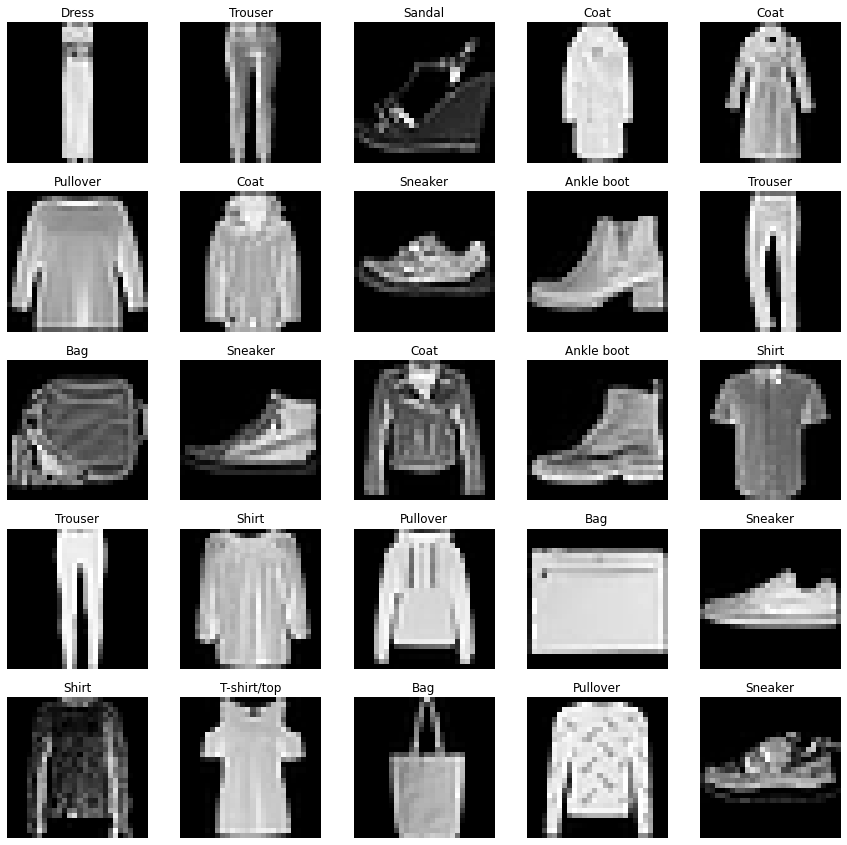

In [5]:
visualize_FMNIST(x=train_images, y=train_labels, classes=classes, grid_size=5)

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

### TODO: Define the Net

Define the layers of your **best, saved model from the classification exercise** in the function `__init__` and define the feedforward behavior of that Net in the function `forward`. Defining the architecture here, will allow you to instantiate and load your best Net.

In [8]:
class Net(nn.Module):

    conv1: nn.Conv2d
    conv2: nn.Conv2d
    pool1: nn.MaxPool2d
    conv3: nn.Conv2d
    pool2: nn.MaxPool2d
    fc1: nn.Linear

    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=5 * 5 * 40, out_features=num_classes)
        

    ## TODO: define the feedforward behavior
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.reshape(input=x, shape=(-1, 5 * 5 * 40))
        x = self.fc1(x)
        
        # final output
        return x


model: Net = Net(num_classes=len(classes)).to(device=Device)
print(f'Model layers: {model}')
print(f'Model summary: {summary(model=model, input_size=(batch_size, 1, 28, 28))}')

Model layers: Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1000, out_features=10, bias=True)
)
Model summary: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [32, 10, 26, 26]          100
├─Conv2d: 1-2                            [32, 20, 24, 24]          1,820
├─MaxPool2d: 1-3                         [32, 20, 12, 12]          --
├─Conv2d: 1-4                            [32, 40, 10, 10]          7,240
├─MaxPool2d: 1-5         

In [11]:
# Instantiate loss function and optimization algorithm
loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: optim.Adam = optim.Adam(params=model.parameters(), lr=1e-3)

In [12]:
correct: int = 0
total: int = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  tensor(13.7600, device='cuda:0')


#### Model Training

In [13]:
def train(n_epochs: int, model: Net, train_dl: DataLoader, optimizer: optim.Adam, 
        loss_fn: nn.CrossEntropyLoss) -> None:
    """Runs epochs to train the model"""
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss: float = 0.0
        for batch_i, data in enumerate(train_dl):
            # Get the input images and their corresponding labels
            images, labels = data       

            # Zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            pred: torch.Tensor = model(images)

            # calculate the loss
            loss: torch.Tensor = loss_fn(pred, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [14]:
# define the number of epochs to train for
num_epochs: int = 20 # start small to see if your model works, initially

# call train
train(n_epochs=num_epochs, model=model, train_dl=train_loader, optimizer=optimizer, loss_fn=loss_fn)

Epoch: 1, Batch: 1000, Avg. Loss: 0.5755092710405588
Epoch: 2, Batch: 1000, Avg. Loss: 0.3357917055860162
Epoch: 3, Batch: 1000, Avg. Loss: 0.2912547043301165
Epoch: 4, Batch: 1000, Avg. Loss: 0.2732085182107985
Epoch: 5, Batch: 1000, Avg. Loss: 0.2512312365658581
Epoch: 6, Batch: 1000, Avg. Loss: 0.23374342445190996
Epoch: 7, Batch: 1000, Avg. Loss: 0.2244268879862502
Epoch: 8, Batch: 1000, Avg. Loss: 0.21430461823567748
Epoch: 9, Batch: 1000, Avg. Loss: 0.20891612423304468
Epoch: 10, Batch: 1000, Avg. Loss: 0.199942020541057
Epoch: 11, Batch: 1000, Avg. Loss: 0.19738171645533292
Epoch: 12, Batch: 1000, Avg. Loss: 0.1915030298549682
Epoch: 13, Batch: 1000, Avg. Loss: 0.1857839793590829
Epoch: 14, Batch: 1000, Avg. Loss: 0.18034122746624054
Epoch: 15, Batch: 1000, Avg. Loss: 0.18012624307442457
Epoch: 16, Batch: 1000, Avg. Loss: 0.17641771287331356
Epoch: 17, Batch: 1000, Avg. Loss: 0.1765725340845529
Epoch: 18, Batch: 1000, Avg. Loss: 0.1749331696499139
Epoch: 19, Batch: 1000, Avg. Lo

#### Evaluate model on test set

In [16]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss: torch.Tensor = torch.zeros(1)
class_correct: List[int] = list(0. for i in range(10))
class_total: List[int] = list(0. for i in range(10))

# Set the module to evaluation mode
model.eval()

# Iterate over the test batches (a single batch in this case) and predict.
# We have put the model in evaluation mode, hence no grad would be computed 
# and no parameters would be updated.
for batch_i, data in enumerate(test_loader):
    
    # Get the input images and their corresponding labels
    inputs, labels = data
    
    # Forward pass to get outputs
    pred: torch.Tensor = model(inputs)

    # Calculate the loss
    loss: torch.Tensor = loss_fn(pred, labels)
    
    # Update average test loss. In our case we have a single batch. Hence the following 
    # statement is equivalent of computing test_loss += loss.data
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data.cpu() - test_loss))
    
    # Get the predicted class from the maximum value in the output-list of class scores
    _, predicted_class = torch.max(input=pred.data, dim=1)
    
    # Compare predictions to true label
    correct = np.squeeze(predicted_class.eq(labels.data.view_as(predicted_class)))
    
    # Calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.373772

Test Accuracy of T-shirt/top: 50% ( 1/ 2)
Test Accuracy of Trouser: 100% ( 5/ 5)
Test Accuracy of Pullover: 100% ( 3/ 3)
Test Accuracy of Dress: 100% ( 2/ 2)
Test Accuracy of  Coat: 80% ( 4/ 5)
Test Accuracy of Sandal: 100% ( 3/ 3)
Test Accuracy of Shirt: 100% ( 3/ 3)
Test Accuracy of Sneaker: 100% ( 3/ 3)
Test Accuracy of   Bag: 100% ( 3/ 3)
Test Accuracy of Ankle boot: 66% ( 2/ 3)

Test Accuracy (Overall): 90% (29/32)


#### Save Model

In [17]:
model_path: str = Path().absolute().joinpath('saved_models/my_model.pt').__str__()
torch.save(model.state_dict(), f=model_path)

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters. This notebook needs to know the network architecture, as defined above, and once it knows what the "Net" class looks like, we can instantiate a model and load in an already trained network.

You should have a trained net in `saved_models/`.


In [10]:
# instantiate your Net
loaded_model: Net = Net(num_classes=len(classes))

model_path: str = Path().absolute().joinpath('saved_models/my_model.pt').__str__()
# load the net parameters by name, uncomment the line below to load your model
loaded_model.load_state_dict(torch.load(model_path))

summary(model=loaded_model, input_size=(32, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [32, 10, 26, 26]          100
├─Conv2d: 1-2                            [32, 20, 24, 24]          1,820
├─MaxPool2d: 1-3                         [32, 20, 12, 12]          --
├─Conv2d: 1-4                            [32, 40, 10, 10]          7,240
├─MaxPool2d: 1-5                         [32, 40, 5, 5]            --
├─Linear: 1-6                            [32, 10]                  10,010
Total params: 19,170
Trainable params: 19,170
Non-trainable params: 0
Total mult-adds (M): 59.20
Input size (MB): 0.10
Forward/backward pass size (MB): 5.71
Params size (MB): 0.08
Estimated Total Size (MB): 5.88

## Feature Visualization

To see what your network has learned, make a plot of the learned image filter weights and the activation maps (for a given image) at each convolutional layer.

### TODO: Visualize the learned filter weights and activation maps of the convolutional layers in your trained Net

Choose a sample input image and apply the filters in every convolutional layer to that image to see the activation map.

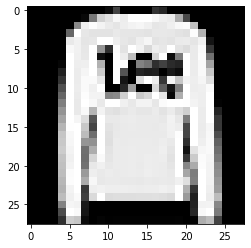

In [28]:
idx: int = 1
img: np.ndarray = test_data.data[idx].numpy()
plt.imshow(img, cmap='gray')

#### Visualize convolution layer 1

In [22]:
weights1: torch.Tensor = loaded_model.conv1.weight.cpu().data
wt1: np.ndarray = weights1.numpy()
wt1 = np.squeeze(wt1, axis=1)
wt1.shape

(10, 3, 3)

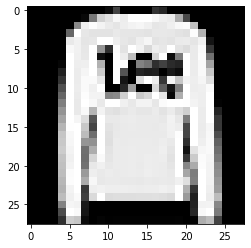

In [42]:
plt.imshow(img, cmap='gray')

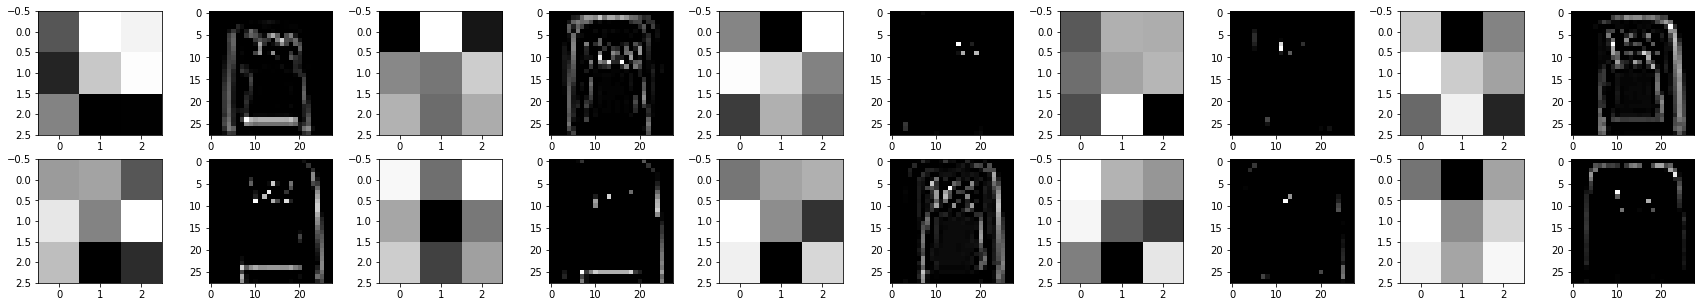

In [30]:
fig: plt.Figure = plt.figure(figsize=(30, 5))
col: int = 5 * 2
row: int = 2
for ix in range(col * row):
    fig.add_subplot(row, col, ix+1)
    if ix % 2 == 0:
        plt.imshow(wt1[int(ix/2)], cmap='gray')
    else:
        kernel: np.ndarray = wt1[int((ix - 1) / 2)]
        ftd: np.ndarray = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
        plt.imshow(ftd, cmap='gray')
plt.show()

#### Visualize convolution layer 2

In [33]:
weights2: torch.Tensor = loaded_model.conv2.weight.cpu().data
wt2: np.ndarray = weights2.numpy()
wt2.shape

(20, 10, 3, 3)

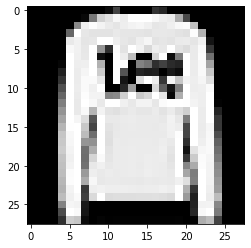

In [43]:
plt.imshow(img, cmap='gray')

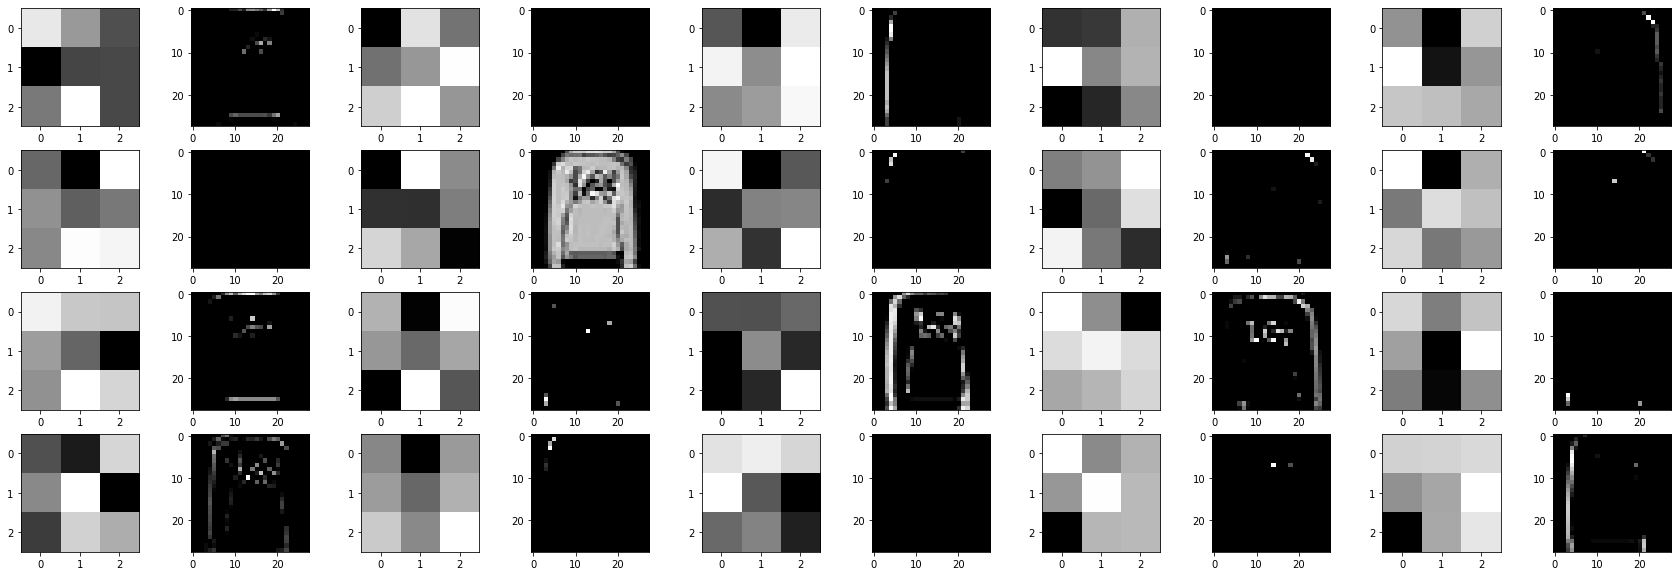

In [40]:
fig: plt.Figure = plt.figure(figsize=(30, 10))
col: int = 5 * 2
row: int = 4
for ix in range(col * row):
    fig.add_subplot(row, col, ix+1)
    if ix % 2 == 0:
        plt.imshow(wt2[int(ix/2)][0], cmap='gray')
    else:
        kernel: np.ndarray = wt2[int((ix - 1) / 2)][0]
        ftd: np.ndarray = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
        plt.imshow(ftd, cmap='gray')
plt.show()

#### Visualize convolution layer 3

In [18]:
weights3: torch.Tensor = loaded_model.conv3.weight.cpu().data
wt3: np.ndarray = weights3.numpy()
wt3.shape

(40, 20, 3, 3)

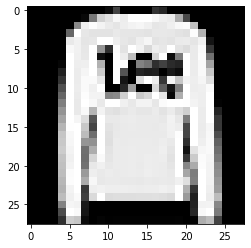

In [44]:
plt.imshow(img, cmap='gray')

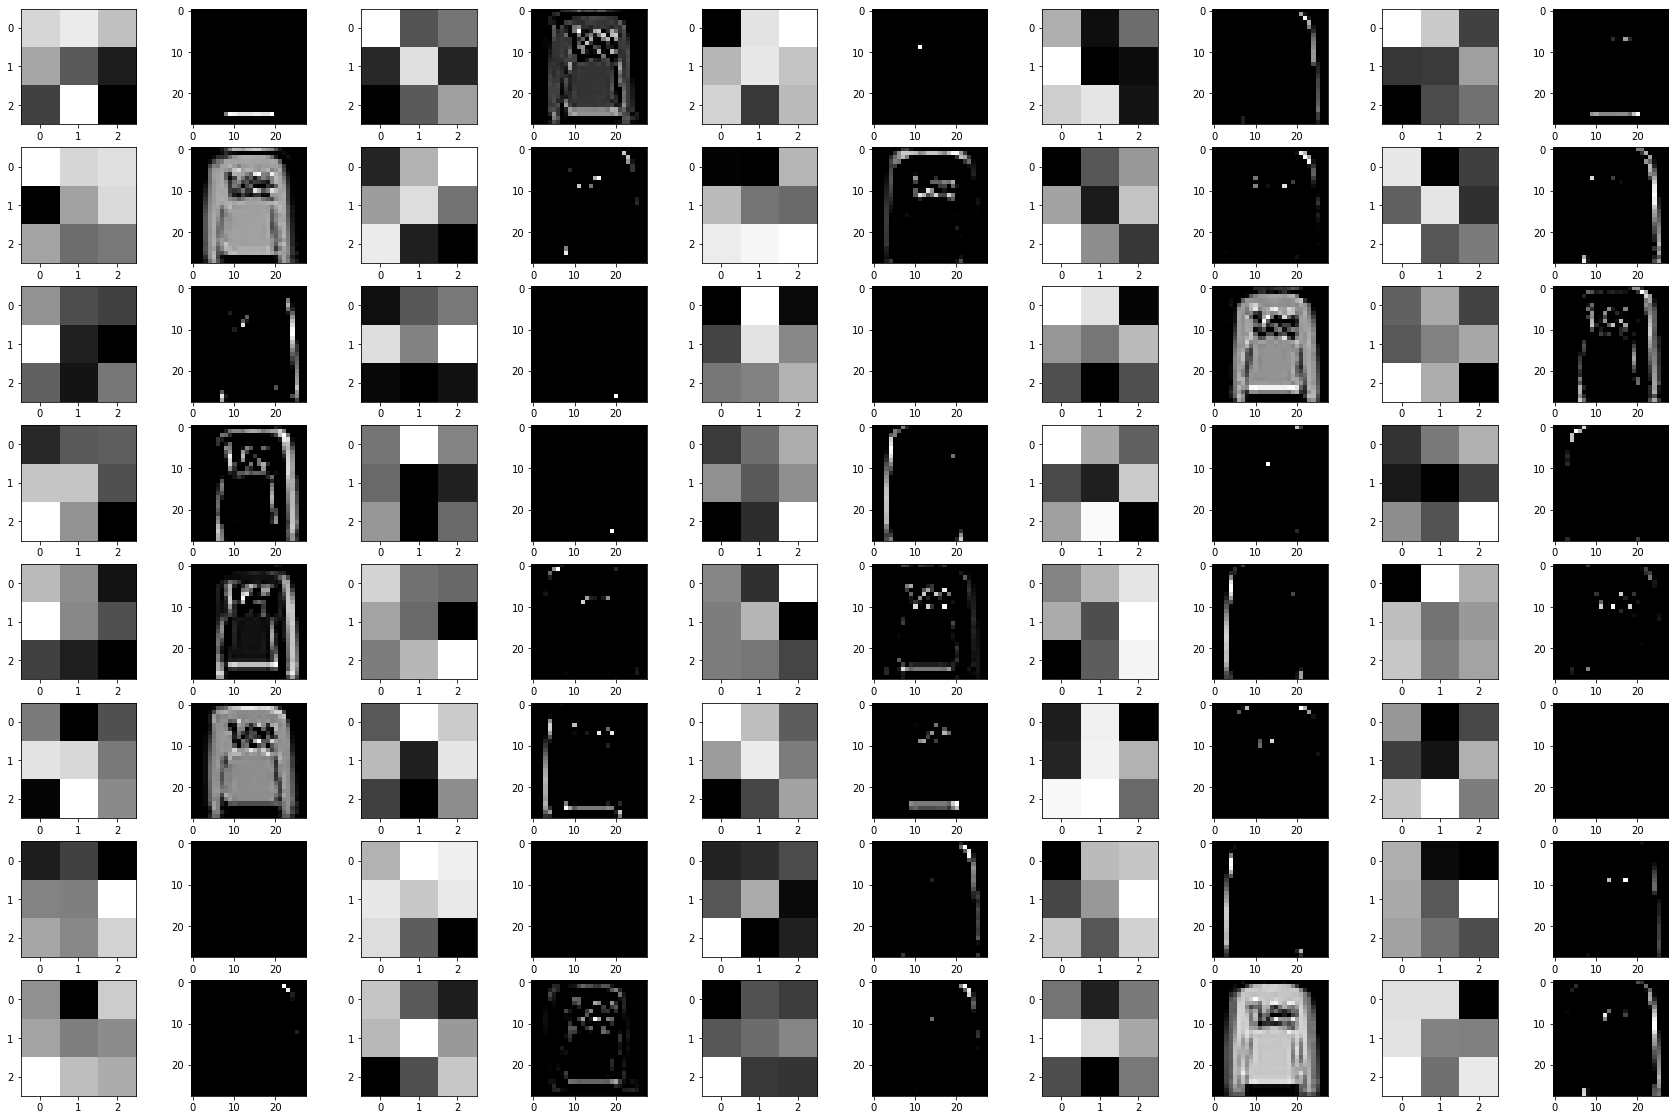

In [41]:
fig: plt.Figure = plt.figure(figsize=(30, 20))
col: int = 5 * 2
row: int = 8
for ix in range(col * row):
    fig.add_subplot(row, col, ix+1)
    if ix % 2 == 0:
        plt.imshow(wt3[int(ix/2)][0], cmap='gray')
    else:
        kernel: np.ndarray = wt3[int((ix - 1) / 2)][0]
        ftd: np.ndarray = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
        plt.imshow(ftd, cmap='gray')
plt.show()

### Question: Choose a filter from one of your trained convolutional layers; looking at these activations, what purpose do you think it plays? What kind of feature do you think it detects?


In the plot above, in the fifth row, fourth set of kernel-image combination clearly denotes a vertical edge detection operation. We have bright columns to the right side and darker columns to the left side of the kernel. Also the very last set of kernel-image combination denote something very similar.

Overall, we see, that as we go deeper in convolutions filters are capable to capture complex patterns in the image. This example is not a good one, because the original image and the kernels are both having low resolutions.